<a href="https://colab.research.google.com/github/Apple03244/Colaboratory/blob/main/Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow.keras as tk
import tensorflow as tf
import pandas as pd
import google.colab as colab

In [2]:
f=colab.files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c titanic

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 37.2MB/s]


In [5]:
!unzip /content/titanic.zip

Archive:  /content/titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


----

## Data load

In [6]:
train=pd.read_csv("/content/train.csv")
test=pd.read_csv("/content/test.csv")

## model making
- 1. Callbacks
- 2. Tensorboard

### 1. make simple network model

In [7]:
import math as mt

preprocessing

In [8]:
import sklearn.preprocessing as skpre
import sklearn.pipeline as skpip
import sklearn.compose as skcom
import sklearn.impute as skimp
import sklearn.base as skbase
import numpy as np

In [9]:
numeric_pipe=skpip.make_pipeline(skimp.KNNImputer(n_neighbors=10))
category_pipe=skpip.make_pipeline(skimp.SimpleImputer(strategy="most_frequent"),
                                  skpre.OneHotEncoder(drop="first",handle_unknown="ignore"))

In [10]:
%%writefile custom_module.py
class passth(skbase.BaseEstimator,skbase.TransformerMixin):
  def __init__(self) -> None:
    super().__init__()

  def fit(self,X,y=None):
    self.columns=X.columns
    return self
  def transform(self,X):
    return X
  def get_feature_names_out(self):
    return self.columns

Writing custom_module.py


In [ ]:
preprocess_pipe=skcom.make_column_transformer((numeric_pipe,["Age","SibSp","Parch","Fare"]),
                                              (category_pipe,["Sex","Embarked"]),
                                              (passth(),["Survived","Pclass"]),
                                              remainder="drop")

In [ ]:
!pip install joblib

In [ ]:
import joblib
import pickle

In [ ]:
joblib.dump(preprocess_pipe,"preprocessing_pipeline.pkl")
test=joblib.load("preprocessing_pipeline.pkl")

In [ ]:
preprocess_pipe.fit(X=train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('knnimputer',
                                                  KNNImputer(n_neighbors=10))]),
                                 ['Age', 'SibSp', 'Parch', 'Fare']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['Sex', 'Embarked']),
                                ('passth', passth(), ['Survived', 'Pclass'])])

In [ ]:
from sys import exec_prefix
pipe_transformers=preprocess_pipe.named_transformers_
column_name=[]
for x in pipe_transformers:
  try:
    column_name.extend(pipe_transformers[x].get_feature_names_out())
  except:
    continue

In [ ]:
pred_train=pd.DataFrame(data=preprocess_pipe.transform(train),columns=column_name)

In [ ]:
pred_train.head(3)

,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Survived,Pclass
0,22.0,1.0,0.0,7.2500,1.0,0.0,1.0,0.0,3.0
1,38.0,1.0,0.0,71.2833,0.0,0.0,0.0,1.0,1.0
2,26.0,0.0,0.0,7.9250,0.0,0.0,1.0,1.0,3.0


make model

In [ ]:
# numeric & category
tf.random.set_seed(10)
# input layer
numeric_input=tk.layers.Input(shape=[4])
category_input=tk.layers.Input(shape=[4])

numeric_normalization_layer=tk.layers.Normalization()
numeric_normalization_layer.adapt(pred_train[["Age","SibSp","Parch","Fare"]])

numeric_normalization=numeric_normalization_layer(numeric_input)
numeric_hidden_1=tk.layers.Dense(units=50,activation="relu")(numeric_normalization)
numeric_hidden_2=tk.layers.Dense(units=50,activation="relu")(numeric_hidden_1)
numeric_output=tk.layers.Dense(units=10,activation="linear")(numeric_hidden_2)

category_hidden_1=tk.layers.Dense(units=50,activation="sigmoid")(category_input)
category_hidden_2=tk.layers.Dense(units=50,activation="sigmoid")(category_hidden_1)
category_output=tk.layers.Dense(units=10,activation="sigmoid")(category_hidden_2)

concate=tk.layers.Concatenate()([numeric_output,category_output])
output_hidden=tk.layers.Dense(units=10,activation="sigmoid")(concate)
total_output=tk.layers.Dense(1,activation="sigmoid")(output_hidden)

model=tk.Model(inputs=(numeric_input,category_input),outputs=total_output)

In [ ]:
# compile
optimizer=tk.optimizers.Adam(learning_rate=0.01)
loss=tk.losses.BinaryCrossentropy()
metrics=tk.metrics.BinaryAccuracy()
model.compile(optimizer=optimizer,loss=loss,metrics=metrics)

#### 1. Use callback method

- checkpoint : 훈련동안 가장 좋은 모델을 저장함
- early_stoppint : 훈련을 멈춤

이 두 방법을 모두 적용하여 과한 학습을 멈추는게 베스트 -> 학습 부담이 상당히 줄어듬

In [ ]:
checkpoint_cb=tk.callbacks.ModelCheckpoint("save_point",save_best_only=True) # monitor : compile 에서 설정된 값을 그대로 가져옴

In [ ]:
early_stop_cb=tk.callbacks.EarlyStopping(patience=10,restore_best_weights=True) # restore_best_weight=True 이므로 최고의 모델로 되돌림

In [ ]:
history=model.fit(x=(pred_train[["Age","SibSp","Parch","Fare"]],pred_train[["Sex_male","Embarked_Q","Embarked_S","Pclass"]]),
          y=pred_train["Survived"],
          epochs=100,
          callbacks=[checkpoint_cb,early_stop_cb],validation_split=0.2,workers=5,use_multiprocessing=True)

Epoch 1/100
18/23 [======================>.......] - ETA: 0s - loss: 0.6605 - binary_accuracy: 0.6042 

23/23 [==============================] - 5s 123ms/step - loss: 0.6626 - binary_accuracy: 0.6067 - val_loss: 0.5508 - val_binary_accuracy: 0.7765
Epoch 2/100
17/23 [=====================>........] - ETA: 0s - loss: 0.5957 - binary_accuracy: 0.7077

23/23 [==============================] - 2s 97ms/step - loss: 0.5954 - binary_accuracy: 0.7079 - val_loss: 0.5159 - val_binary_accuracy: 0.7709
Epoch 3/100
23/23 [==============================] - 0s 7ms/step - loss: 0.5886 - binary_accuracy: 0.7219 - val_loss: 0.5229 - val_binary_accuracy: 0.7765
Epoch 4/100
23/23 [==============================] - 0s 9ms/step - loss: 0.5880 - binary_accuracy: 0.7205 - val_loss: 0.5205 - val_binary_accuracy: 0.7598
Epoch 5/100
23/23 [==============================] - 0s 8ms/step - loss: 0.5825 - binary_accuracy: 0.7107 - val_loss: 0.5228 - val_binary_accuracy: 0.7598
Epoch 6/100
23/23 [==============================] - ETA: 0s - loss: 0.5848 - binary_accuracy: 0.7177

23/23 [==============================] - 3s 132ms/step - loss: 0.5848 - binary_accuracy: 0.7177 - val_loss: 0.5130 - val_binary_accuracy: 0.7654
Epoch 7/100
17/23 [=====================>........] - ETA: 0s - loss: 0.5777 - binary_accuracy: 0.7077

23/23 [==============================] - 4s 187ms/step - loss: 0.5729 - binary_accuracy: 0.7247 - val_loss: 0.5123 - val_binary_accuracy: 0.7877
Epoch 8/100
19/23 [=======================>......] - ETA: 0s - loss: 0.5632 - binary_accuracy: 0.7188

23/23 [==============================] - 4s 159ms/step - loss: 0.5490 - binary_accuracy: 0.7289 - val_loss: 0.4693 - val_binary_accuracy: 0.8101
Epoch 9/100
18/23 [======================>.......] - ETA: 0s - loss: 0.4888 - binary_accuracy: 0.7865

23/23 [==============================] - 2s 92ms/step - loss: 0.4903 - binary_accuracy: 0.7809 - val_loss: 0.3952 - val_binary_accuracy: 0.8436
Epoch 10/100
23/23 [==============================] - 0s 8ms/step - loss: 0.4554 - binary_accuracy: 0.8020 - val_loss: 0.3976 - val_binary_accuracy: 0.8324
Epoch 11/100
21/23 [==========================>...] - ETA: 0s - loss: 0.4516 - binary_accuracy: 0.8006

23/23 [==============================] - 3s 121ms/step - loss: 0.4561 - binary_accuracy: 0.7978 - val_loss: 0.3791 - val_binary_accuracy: 0.8603
Epoch 12/100
23/23 [==============================] - 0s 5ms/step - loss: 0.4501 - binary_accuracy: 0.7949 - val_loss: 0.3946 - val_binary_accuracy: 0.8380
Epoch 13/100
23/23 [==============================] - 0s 6ms/step - loss: 0.4439 - binary_accuracy: 0.7963 - val_loss: 0.3804 - val_binary_accuracy: 0.8436
Epoch 14/100
23/23 [==============================] - 0s 5ms/step - loss: 0.4409 - binary_accuracy: 0.7963 - val_loss: 0.3812 - val_binary_accuracy: 0.8547
Epoch 15/100
23/23 [==============================] - 0s 6ms/step - loss: 0.4371 - binary_accuracy: 0.8104 - val_loss: 0.3812 - val_binary_accuracy: 0.8268
Epoch 16/100
20/23 [=========================>....] - ETA: 0s - loss: 0.4466 - binary_accuracy: 0.8016

23/23 [==============================] - 2s 82ms/step - loss: 0.4346 - binary_accuracy: 0.8076 - val_loss: 0.3718 - val_binary_accuracy: 0.8380
Epoch 17/100
14/23 [=================>............] - ETA: 0s - loss: 0.4214 - binary_accuracy: 0.8147

23/23 [==============================] - 3s 149ms/step - loss: 0.4342 - binary_accuracy: 0.8034 - val_loss: 0.3664 - val_binary_accuracy: 0.8436
Epoch 18/100
23/23 [==============================] - 0s 13ms/step - loss: 0.4326 - binary_accuracy: 0.8076 - val_loss: 0.3739 - val_binary_accuracy: 0.8380
Epoch 19/100
23/23 [==============================] - 0s 11ms/step - loss: 0.4324 - binary_accuracy: 0.8034 - val_loss: 0.3910 - val_binary_accuracy: 0.8324
Epoch 20/100
23/23 [==============================] - 0s 11ms/step - loss: 0.4260 - binary_accuracy: 0.8076 - val_loss: 0.3796 - val_binary_accuracy: 0.8268
Epoch 21/100
23/23 [==============================] - 0s 12ms/step - loss: 0.4278 - binary_accuracy: 0.8104 - val_loss: 0.3704 - val_binary_accuracy: 0.8324
Epoch 22/100
23/23 [==============================] - 0s 17ms/step - loss: 0.4204 - binary_accuracy: 0.8118 - val_loss: 0.3849 - val_binary_accuracy: 0.8156
Epoch 23/100
23/23 [==============================] - 0s 10ms/step - l

23/23 [==============================] - 7s 301ms/step - loss: 0.4190 - binary_accuracy: 0.8132 - val_loss: 0.3549 - val_binary_accuracy: 0.8436
Epoch 26/100
23/23 [==============================] - 0s 20ms/step - loss: 0.4139 - binary_accuracy: 0.8188 - val_loss: 0.3809 - val_binary_accuracy: 0.8603
Epoch 27/100
23/23 [==============================] - 0s 14ms/step - loss: 0.4126 - binary_accuracy: 0.8132 - val_loss: 0.3595 - val_binary_accuracy: 0.8436
Epoch 28/100
23/23 [==============================] - 0s 12ms/step - loss: 0.4134 - binary_accuracy: 0.8230 - val_loss: 0.3873 - val_binary_accuracy: 0.8492
Epoch 29/100
23/23 [==============================] - 0s 11ms/step - loss: 0.4078 - binary_accuracy: 0.8244 - val_loss: 0.3939 - val_binary_accuracy: 0.7877
Epoch 30/100
23/23 [==============================] - 0s 11ms/step - loss: 0.4153 - binary_accuracy: 0.8118 - val_loss: 0.3925 - val_binary_accuracy: 0.8268
Epoch 31/100
23/23 [==============================] - 0s 19ms/step - l

In [ ]:
history_datas=pd.DataFrame(history.history)

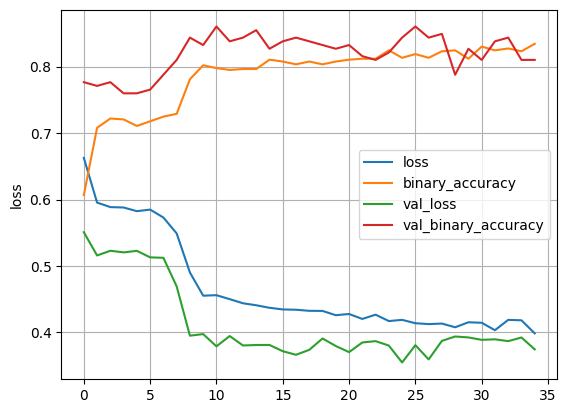

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sb
plt.figure()
for col in history_datas.columns:
  sb.lineplot(x=history_datas.index,y=history_datas[col],label=col)
plt.grid()
plt.show()

In [ ]:
submission=pd.read_csv("/content/gender_submission.csv")

In [ ]:
test_data=pd.merge(test,submission,left_on=["PassengerId"],right_on=["PassengerId"])

In [ ]:
preprocess_pipe.fit(test_data)
column_name=[]
for x in preprocess_pipe.named_transformers_:
  try:
    column_name.extend(preprocess_pipe.named_transformers_[x].get_feature_names_out())
  except:
    continue

In [ ]:
pre_test_data=pd.DataFrame(preprocess_pipe.transform(test_data),columns=column_name)

In [ ]:
pre_test_data.head(3)

,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Survived,Pclass
0,34.5,0.0,0.0,7.8292,1.0,1.0,0.0,0.0,3.0
1,47.0,1.0,0.0,7.0000,0.0,0.0,1.0,1.0,3.0
2,62.0,0.0,0.0,9.6875,1.0,1.0,0.0,0.0,2.0


In [ ]:
model.evaluate(x=(pre_test_data[["Age","SibSp","Parch","Fare"]],pre_test_data[["Sex_male","Embarked_Q","Embarked_S","Pclass"]]),
               y=pre_test_data["Survived"],
               return_dict=True)

14/14 [==============================] - 0s 4ms/step - loss: 0.2871 - binary_accuracy: 0.9211


{'loss': 0.2870769500732422, 'binary_accuracy': 0.9210526347160339}

In [ ]:
predict_dataset=pd.DataFrame(model.predict(x=(pre_test_data[["Age","SibSp","Parch","Fare"]],pre_test_data[["Sex_male","Embarked_Q","Embarked_S","Pclass"]]))
,columns=["predict_proba"])

14/14 [==============================] - 0s 4ms/step


In [ ]:
predict_dataset['predict']=predict_dataset.applymap(lambda x:0 if x<0.5 else 1)

#### Confusion matrix

In [ ]:
import sklearn.metrics as skmet
import matplotlib.pyplot as plt
import seaborn as sb

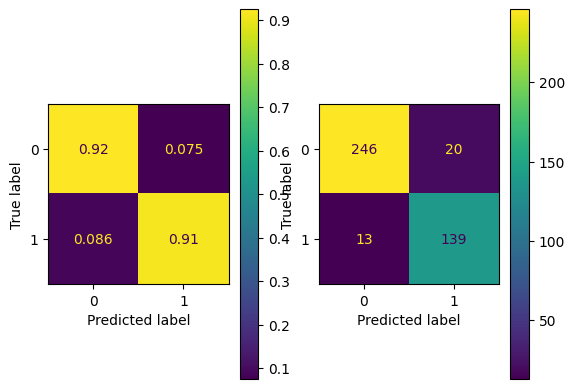

In [ ]:
_,a=plt.subplots(1,2)
skmet.ConfusionMatrixDisplay.from_predictions(y_true=test_data["Survived"],y_pred=predict_dataset["predict"],
                                              normalize="true",ax=a[0])
skmet.ConfusionMatrixDisplay.from_predictions(y_true=test_data["Survived"],y_pred=predict_dataset["predict"],
                                              normalize=None,ax=a[1])

### Save model

In [ ]:
xxxx

In [ ]:
model.save("titanic_predictor",save_format="tf")

In [ ]:
!zip -r /content/titanic_predictor.zip /content/titanic_predictor

  adding: content/titanic_predictor/ (stored 0%)
  adding: content/titanic_predictor/fingerprint.pb (stored 0%)
  adding: content/titanic_predictor/saved_model.pb (deflated 88%)
  adding: content/titanic_predictor/variables/ (stored 0%)
  adding: content/titanic_predictor/variables/variables.index (deflated 67%)
  adding: content/titanic_predictor/variables/variables.data-00000-of-00001 (deflated 15%)
  adding: content/titanic_predictor/assets/ (stored 0%)
  adding: content/titanic_predictor/keras_metadata.pb (deflated 92%)


In [ ]:
submission
submission["Survived"] = predict_dataset[["predict"]]
submission.to_csv('/content/titanic_submission.csv',index=False)